In [23]:
import pandas as pd

# Load per-bout STPD-corrected metabolic data
bout_df = pd.read_csv("C:/Users/labadmin/Documents/Uppsala analyses/metabolic_rates_stpd_corrected.csv")

# Load trial-level RQ from raw (uncorrected) data
trial_df = pd.read_csv("C:/Users/labadmin/Documents/Uppsala analyses/filtered_bee_floral_metabolic_rates.csv")

# Standardize BeeID formatting
bout_df["BeeID"] = bout_df["BeeID"].str.strip().str.lower()
trial_df["BeeID"] = trial_df["BeeID"].str.strip().str.lower()

# Merge in raw RQ
merged_df = bout_df.merge(trial_df[["BeeID", "RQ_raw"]], on="BeeID", how="left")

# Load BeeID-to-colony_id mapping
colony_map = pd.read_excel("C:/Users/labadmin/Documents/Uppsala analyses/beeID laser file name + weight.xlsx")

# Standardize BeeID formatting and rename column
colony_map["BeeID"] = colony_map["BeeID"].str.strip().str.lower()
colony_map = colony_map.rename(columns={"ColonyID": "colony_id"})

# Merge in colony_id
merged_df = merged_df.merge(colony_map[["BeeID", "colony_id"]], on="BeeID", how="left")

# Drop rows with missing RQ, CO2 rate, or weight
merged_df = merged_df.dropna(subset=["RQ_raw", "CO2_rate_mL_h_STPD", "weight_g"])

In [24]:
# Estimate VO2 from CO2 and RQ
merged_df["Estimated_O2_mL_h"] = merged_df["CO2_rate_mL_h_STPD"] / merged_df["RQ_raw"]

# Compute Lighton's oxyjoule equivalent
merged_df["Oxyjoule_Equivalent_J_per_mL"] = 15.97 + 5.164 * merged_df["RQ_raw"]

# Compute power in Watts
merged_df["Power_W"] = (
    merged_df["Estimated_O2_mL_h"] *
    merged_df["Oxyjoule_Equivalent_J_per_mL"] / 3600
)

# Compute energy in Joules
merged_df["Energy_J"] = merged_df["Power_W"] * merged_df["dt_sec"]

# Compute mass-specific energy (J/kg)
merged_df["Energy_J_per_kg"] = merged_df["Energy_J"] / (merged_df["weight_g"] / 1000)

# Compute mass-specific power (W/kg)
merged_df["Power_W_per_kg"] = merged_df["Power_W"] / (merged_df["weight_g"] / 1000)

In [25]:
# Preview output
merged_df[[
    "BeeID", "colony_id", "event_type", "RQ_raw", "CO2_rate_mL_h_STPD", "Estimated_O2_mL_h",
    "Oxyjoule_Equivalent_J_per_mL", "Energy_J", "Power_W", "Energy_J_per_kg", "Power_W_per_kg"
]].head()


,BeeID,colony_id,event_type,RQ_raw,CO2_rate_mL_h_STPD,Estimated_O2_mL_h,Oxyjoule_Equivalent_J_per_mL,Energy_J,Power_W,Energy_J_per_kg,Power_W_per_kg
0,green3,3,buzz,0.96191,5.590133,5.811492,20.937303,0.067598,0.033799,373.471385,186.735693
1,green3,3,buzz,0.96191,5.635173,5.858316,20.937303,0.034071,0.034071,188.240246,188.240246
2,green3,3,buzz,0.96191,5.681205,5.906171,20.937303,0.068700,0.034350,379.555830,189.777915
3,green3,3,buzz,0.96191,5.727241,5.954030,20.937303,0.034628,0.034628,191.315740,191.315740
4,green3,3,buzz,0.96191,6.111753,6.353768,20.937303,0.073906,0.036953,408.320335,204.160168


In [26]:
# Save results
merged_df.to_csv("C:/Users/labadmin/Documents/Uppsala analyses/bee_bout_power_output.csv", index=False)
print("✅ Power estimates saved to 'bee_bout_power_output.csv'")

✅ Power estimates saved to 'bee_bout_power_output.csv'


📊 Summary (Power by Behavior):
             Power_W                 Power_W_per_kg                  
                mean       std count           mean         std count
event_type                                                           
buzz        0.063572  0.017761   260     308.324931   97.142989   260
flight      0.066449  0.021633   213     358.174918  148.260955   213


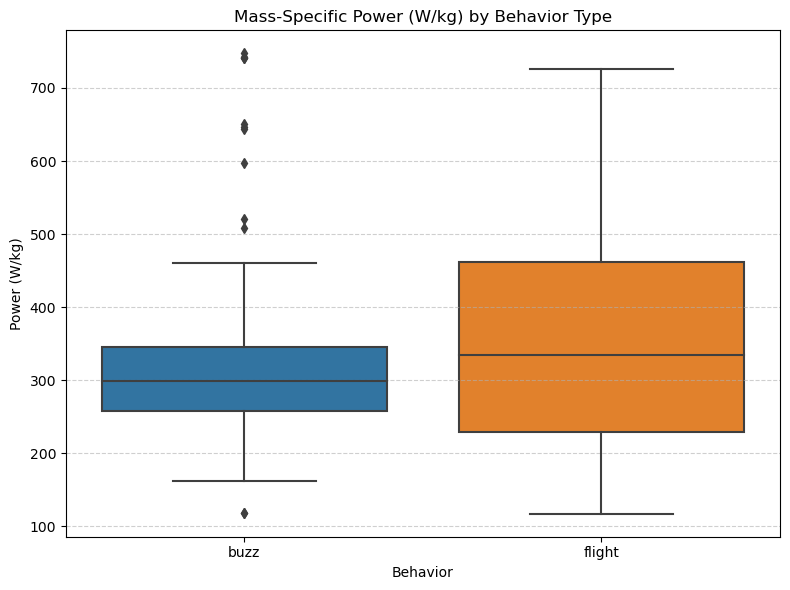

In [8]:
# === Summary Statistics by Behavior ===
summary = merged_df.groupby("event_type")[["Power_W", "Power_W_per_kg"]].agg(["mean", "std", "count"])
print("📊 Summary (Power by Behavior):")
print(summary)

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x="event_type", y="Power_W_per_kg")
plt.title("Mass-Specific Power (W/kg) by Behavior Type")
plt.ylabel("Power (W/kg)")
plt.xlabel("Behavior")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

# Load your updated file with colony_id
df_power = pd.read_csv("C:/Users/labadmin/Documents/Uppsala analyses/bee_bout_power_output.csv")

# --- Convert weight to mg ---
df_power["body_mass_mg"] = df_power["weight_g"] * 1000

# --- Optional: standardise event_type (e.g., rename "flight" to "takeoff") ---
df_power["event_type"] = df_power["event_type"].replace("flight", "takeoff")

# --- Aggregate power per bee per behaviour ---
summary_power = (
    df_power.groupby(["BeeID", "colony_id", "event_type"])
    .agg(
        mean_energy_J=("Energy_J", "mean"),
        mean_power_W=("Power_W", "mean"),
        mean_energy_J_per_kg=("Energy_J_per_kg", "mean"),
        mean_power_W_per_kg=("Power_W_per_kg", "mean"),
        body_mass_mg=("body_mass_mg", "first")  # assumed constant per bee
    )
    .reset_index()
)

# --- Save to CSV for later analysis in R or Python ---
summary_power.to_csv("C:/Users/labadmin/Documents/Uppsala analyses/mean_energy_per_bee.csv", index=False)

# Preview the tidy dataset
summary_power.head()

,BeeID,colony_id,event_type,mean_energy_J,mean_power_W,mean_energy_J_per_kg,mean_power_W_per_kg,body_mass_mg
0,green3,3,buzz,0.069996,0.036804,386.718033,203.338553,181.0
1,green3,3,takeoff,0.087094,0.064305,481.184794,355.275202,181.0
2,green4,4,buzz,0.097090,0.078015,448.453468,360.348370,216.5
3,green4,4,takeoff,0.109043,0.087242,503.664332,402.964550,216.5
4,green5,5,buzz,0.098550,0.059478,369.794869,223.181334,266.5
